## Simulador de Recorridos ciclistas

### Importamos librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from keras.models import load_model
import pickle
import time

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Como tenemos procesado todo en el mismo fichero, lo cargamos

#path = '../Entrenamientos/Procesado_Tramos.xlsx'
path = '../Entrenamientos/Procesado_Tramos_simulacion.xlsx'
df = pd.read_excel(path)

### Filtramos datos

In [3]:
#Eliminar las filas que no tienen datos y seleccionamos la prueba que queremos simular
df = df[df["porc"]!=np.inf]
#df = df[df["prueba"]=="20180429_LEMG_195_90_R_C.gpx"]

In [4]:
df.describe()

,tramo,tramo_inicial,tramo_final,dist,viento_aparente,porc,dist_acum
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,41.500000,1220.797619,1252.880952,507.744281,-0.587996,-0.047731,19509.435551
std,24.392622,777.046195,781.656619,693.744429,5.336408,1.819731,12154.558566
min,0.000000,0.000000,25.000000,12.158278,-9.954147,-4.645913,329.544198
25%,20.750000,529.750000,609.500000,25.516494,-4.099877,-0.565377,9742.611994
50%,41.500000,1235.500000,1266.000000,145.726222,-1.248373,0.001432,19614.673821
75%,62.250000,1779.000000,1797.500000,784.964079,2.888754,0.363841,27829.260059
max,83.000000,2663.000000,2695.000000,3454.663686,9.997376,4.950157,42624.028333


In [5]:
#Se revisa que no existan datos anómalos
df.head()

,tramo,tramo_inicial,tramo_final,dist,viento_aparente,porc,dist_acum,prueba
0,0,0,25,344.041550,3.492273,1.596116,329.544198,xxxxxxxx_LEVS_195_90_R_E.gpx
1,1,25,26,13.567297,1.574548,-0.218832,344.041550,xxxxxxxx_LEVS_195_90_R_E.gpx
2,2,26,37,168.993513,1.731397,0.371159,509.985494,xxxxxxxx_LEVS_195_90_R_E.gpx
3,3,37,38,17.331806,1.575208,-0.067596,526.602360,xxxxxxxx_LEVS_195_90_R_E.gpx
4,4,38,41,48.498332,3.407638,0.074144,579.260182,xxxxxxxx_LEVS_195_90_R_E.gpx


(array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 1., 1., 4., 5., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 3., 6., 7., 6., 7., 4.,
        5., 3., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        2., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0.,
        1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-4.64591325, -4.54995255, -4.45399185, -4.35803115, -4.26207045,
        -4.16610974, -4.07014904, -3.97418834, -3.87822764, -3.78226694,
        -3.68630624, -3.59034553, -3.49438483, -3.39842413, -3.30246343,
        -3.20650273, -3.11054202, -3.01458132, -2.91862062, -2.82265992,
        -2.72669922, -2.63073852, -2.53477781, -2.43881711, -2.34285641,
        -2.24689571, -2.15093501, -2.05497431, -1.9590136 , -1.8630529 ,
        -1.7670922 , -1.6711315 , -1.5751708 , -1.4792101 , -1.38324939,
        -1.28728869, -1.19132799, -1.09

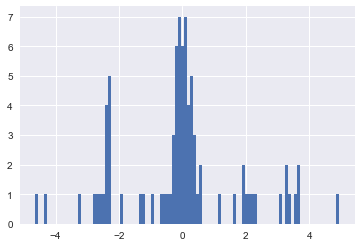

In [6]:
plt.hist(df['porc'],bins=100)

Vemos que la mayoría de tramos están centrados en porcentajes cercanos a 0, aunque también hay varios tramos de subidas y bajadas

In [7]:
#Prueba iterando en cada tramo con intervalos aleatorios con el modelo desarrollado CON TENSORFLOW (PRIMERA PASADA)

#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Cargamos los dos modelos con los que vamos a trabajar
model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 50 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Las siguientes variables se rellenan a criterio del entrenador o de quien use esta simulación
potencia_objetivo = 210
pot_min = 65
pot_max = 285
ff_1 = 0.6
ff_2 = 0.35

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d, llevamos %d exitos y %d fracasos' %(fi,exito,fail))
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    bins_potencias = [0] * 30
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
   
    
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        
        if viento<0:
            min_random = (viento/2)-1
            max_random = abs(viento**2)+1
        else:
            max_random = (viento/2)+1
            min_random = (-1*viento**2)-1
            
        potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))*(np.random.randint(min_random,max_random)+100)/100
        #potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-100,100)
        potencia_min = pot_min+(pot_max-50-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
        potencia_max = pot_min+50+(pot_max-pot_min-50)/(1+ff_1*np.e**(ff_2*porc*-1))
                                            
        if potencia_aux>potencia_max:
            potencia = potencia_max
        elif potencia_aux<potencia_min:
            potencia = potencia_min
        else:
            potencia = potencia_aux
        
        
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        #acumulamos el tiempo que se pasa en cada agrupacion de potencias
        bins_potencias[int(potencia/10)] =bins_potencias[int(potencia/10)] + nuevo_tiempo[0]
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d y tiempo %d" %(fi, potencia_media, tiempo_acum))
    
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-5) and (potencia_media < potencia_objetivo+5) and sum(bins_potencias[-5:])<1200:
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
        print("Tiempo por encimade de 250w:", sum(bins_potencias[-5:]))
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

Empezamos la prueba 0, llevamos 0 exitos y 0 fracasos
--- 0.9827675819396973 seconds ---
Intento 0 con potencia media 211 y tiempo 5123
Intento 1 con potencia media 210 y tiempo 5128
Tiempo por encimade de 250w: 1271.6473083496094
Intento 2 con potencia media 209 y tiempo 5132
Tiempo por encimade de 250w: 1277.3992614746094
Intento 3 con potencia media 212 y tiempo 5109
Tiempo por encimade de 250w: 1627.704574584961
Intento 4 con potencia media 210 y tiempo 5123
Tiempo por encimade de 250w: 1269.7518310546875
Intento 5 con potencia media 211 y tiempo 5123
Intento 6 con potencia media 209 y tiempo 5136
Tiempo por encimade de 250w: 1274.4635925292969
Intento 7 con potencia media 210 y tiempo 5134
Intento 8 con potencia media 211 y tiempo 5125
Tiempo por encimade de 250w: 1320.9309692382812
Intento 9 con potencia media 211 y tiempo 5118
Empezamos la prueba 10, llevamos 4 exitos y 6 fracasos
--- 1.820415735244751 seconds ---
Intento 10 con potencia media 210 y tiempo 5123
Tiempo por encima

In [8]:
histo_pot = pd.DataFrame(bins_potencias)
histo_pot[potencia]=histo_pot.index.values*10
histo_pot.columns = ['segundos','potencia']
histo_pot

,segundos,potencia
0,0.000000,0
1,0.000000,10
2,0.000000,20
3,0.000000,30
4,0.000000,40
5,0.000000,50
6,0.000000,60
7,0.000000,70
8,0.000000,80
9,0.000000,90


In [9]:
sum(bins_potencias[-5:])

1009.2711486816406

In [10]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ('intento','pwr','secs','list')
ds

,intento,pwr,secs,list
0,0,211.166687,5123.227051,"[[0, 217.3237578947572, 27.184458, 344.0415503..."
1,5,211.030701,5123.031738,"[[0, 228.78898698360987, 27.909119, 344.041550..."
2,7,210.016602,5134.818359,"[[0, 220.59953763442937, 27.391504, 344.041550..."
3,9,211.375122,5118.954590,"[[0, 225.51320724393767, 27.702074, 344.041550..."
4,11,209.888031,5133.905273,"[[0, 212.4100882852489, 26.87389, 344.04155036..."
5,12,212.174179,5109.732910,"[[0, 225.51320724393767, 27.702074, 344.041550..."
6,13,209.301651,5145.297363,"[[0, 215.6858680249211, 27.080935, 344.0415503..."
7,14,210.977402,5117.321289,"[[0, 212.4100882852489, 26.87389, 344.04155036..."
8,15,210.627762,5128.135254,"[[0, 212.4100882852489, 26.87389, 344.04155036..."
9,18,209.393539,5141.620605,"[[0, 222.23742750426547, 27.495031, 344.041550..."


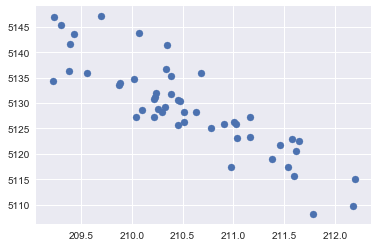

In [11]:
plt.scatter(ds['pwr'],ds['secs'])

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

(array([2., 1., 2., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 2., 2., 0., 3.,
        2., 4., 2., 2., 3., 0., 1., 1., 0., 1., 0., 1., 1., 3., 0., 2., 0.,
        0., 0., 1., 1., 1., 2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 2.]),
 array([209.22109985, 209.28059906, 209.34009827, 209.39959747,
        209.45909668, 209.51859589, 209.57809509, 209.6375943 ,
        209.69709351, 209.75659271, 209.81609192, 209.87559113,
        209.93509033, 209.99458954, 210.05408875, 210.11358795,
        210.17308716, 210.23258636, 210.29208557, 210.35158478,
        210.41108398, 210.47058319, 210.5300824 , 210.5895816 ,
        210.64908081, 210.70858002, 210.76807922, 210.82757843,
        210.88707764, 210.94657684, 211.00607605, 211.06557526,
        211.12507446, 211.18457367, 211.24407288, 211.30357208,
        211.36307129, 211.4225705 , 211.4820697 , 211.54156891,
        211.60106812, 211.66056732, 211.72006653, 211.77956573,
        211.83906494, 211.89856415, 211.95806335, 212.01756256,
      

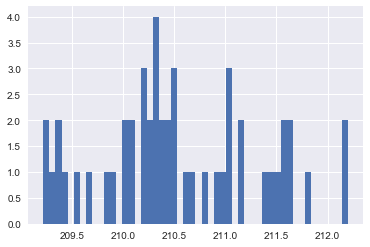

In [12]:
plt.hist(ds['pwr'],bins=50)

Histograma de potencias validas para la simulación

In [13]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

5108.19775390625

In [14]:
#Nos quedamos con los 50 mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']==a[:1].max()][['intento','list']])
ganadores

,intento,list
48,85,"[[0, 227.15109711377377, 27.805597, 344.041550..."


In [15]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador.head()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,227.151097,27.805597,344.041550,44.543175,1.596116,3.492273,85
1,1,197.179408,34.814007,13.567297,1.402949,-0.218832,1.574548,85
2,2,207.641309,32.529762,168.993513,18.702154,0.371159,1.731397,85
3,3,199.913785,34.227436,17.331806,1.822938,-0.067596,1.575208,85
4,4,187.173623,32.912430,48.498332,5.304804,0.074144,3.407638,85


In [16]:
df_ganador.describe()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.0
mean,41.500000,199.967533,33.621381,507.744281,60.811881,-0.047731,-0.587996,85.0
std,24.392622,32.551244,6.581642,693.744429,87.510858,1.819731,5.336408,0.0
min,0.000000,106.972071,17.322487,12.158278,1.308610,-4.645913,-9.954147,85.0
25%,20.750000,180.672213,31.974372,25.516494,2.839566,-0.565377,-4.099877,85.0
50%,41.500000,203.311061,33.632227,145.726222,16.006377,0.001432,-1.248373,85.0
75%,62.250000,219.145718,36.169835,784.964079,77.765985,0.363841,2.888754,85.0
max,83.000000,268.693264,48.895836,3454.663686,344.280548,4.950157,9.997376,85.0


(array([ 2.,  1.,  6.,  7.,  7., 21., 20.,  8.,  9.,  3.]),
 array([106.972071  , 123.14419029, 139.31630959, 155.48842888,
        171.66054818, 187.83266747, 204.00478677, 220.17690606,
        236.34902536, 252.52114465, 268.69326395]),
 <a list of 10 Patch objects>)

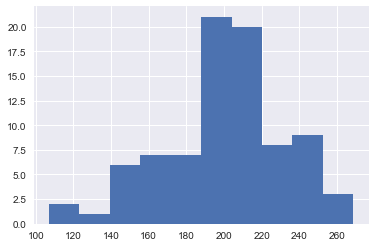

In [20]:
plt.hist(df_ganador['Potencia'].values)

(array([ 2.,  2., 13.,  3., 33., 15.,  5.,  3.,  7.,  1.]),
 array([-4.64591325, -3.68630624, -2.72669922, -1.7670922 , -0.80748518,
         0.15212183,  1.11172885,  2.07133587,  3.03094289,  3.9905499 ,
         4.95015692]),
 <a list of 10 Patch objects>)

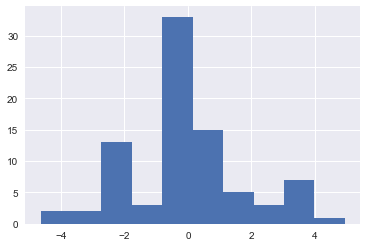

In [21]:
plt.hist(df_ganador['Pendiente'].values)

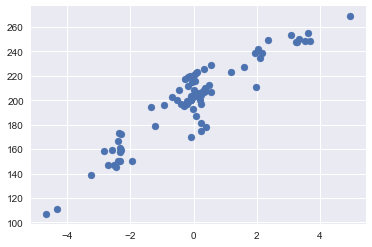

In [23]:
plt.scatter(df_ganador['Pendiente'].values,df_ganador['Potencia'].values)

La distribución de potencia es acorde a lo esperado

In [24]:
#Juntamos el resultado de la simulación con el recorrido original a efectos de comparativa posterior en Tableau
df_input = df[['tramo','pwr','spd','dist','time_seg','porc','viento_aparente']]
df_input.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
df_input['Intento'] = 'Original'
df_input.append([df_ganador]).to_excel('res_sim_ori.xlsx')
df_input.head()

KeyError: "['pwr' 'spd' 'time_seg'] not in index"

In [ ]:
potencias_medias = df_ganador.groupby(['Tramos'])['Potencia'].agg('median')

#### Posible mejora del modelo, inicializando la potencia de cada tramo con el mejor resultado de la primera simulación

In [ ]:
#CON TENSORFLOW (SEGUNDA PASADA)
#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Cargamos los dos modelos con los que vamos a trabajar
model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 50 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Las siguientes variables se rellenan a criterio del entrenador o de quien use esta simulación
potencia_objetivo = 220
pot_min = 60
pot_max = 275
ff_1 = 0.3
ff_2 = 0.7

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        
        if viento<0:
            min_random = (viento/2)-1
            max_random = abs(viento*2)+1
        else:
            max_random = (viento/2)+1
            min_random = (-1*viento*2)-1
                
        potencia_aux = potencias_medias[i]*(np.random.randint(min_random,max_random)+100)/100
        potencia_min = pot_min+(pot_max-30-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
        potencia_max = pot_min+30+(pot_max-pot_min-30)/(1+ff_1*np.e**(ff_2*porc*-1))
                                            
        if potencia_aux>potencia_max:
            potencia = potencia_max
        elif potencia_aux<potencia_min:
            potencia = potencia_min
        else:
            potencia = potencia_aux
    
        
        
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-5) and (potencia_media < potencia_objetivo+5):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

In [ ]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ('intento','pwr','secs','list')
ds

In [ ]:
plt.scatter(ds['pwr'],ds['secs'])

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

In [ ]:
plt.hist(ds['pwr'],bins=50)

Histograma de potencias validas para la simulación

In [ ]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

In [ ]:
#Nos quedamos con los 50 mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']<=a[:50].max()][['intento','list']])
ganadores

In [ ]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador.head()

In [ ]:
df_ganador.describe()

In [ ]:
plt.hist(df_ganador['Potencia'])

In [ ]:
plt.scatter(df_ganador['Pendiente'],df_ganador['Potencia'])